<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Getting Started with the Quantum Experience Web API*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Andreas Fuhrer, Jay M. Gambetta, Andrew Cross

## About
The is a simple example script illustrating the Python interface to the web API of the Quantum Experience. It allows you to run experiments on the Quantum Experience by submitting OPENQASM 2.0 code sequences and reading back the results of the experiments when they become available. 

## Installation
If you have **not** yet installed the Python interface to the web API of the Quantum Experience you can download it from [here](https://github.com/IBMResearch/python-sdk-quantum-experience). Alternatively you can install it using pip from the commandline or by executing (press shift + enter) the following cell:

In [ ]:
!pip install --upgrade IBMQuantumExperience

Should you run into problems you can retry to install from the command line (without the leading '!') or by manually installing each package:<br />
`! pip install --upgrade --no-deps IBMQuantumExperience` <br />
`! pip install --upgrade --no-deps requests` <br />
For some users, it may be necessary to install in user space using the "--user" option. If you prefer, as a final alternative, you can import and call the pip module directly within this notebook.

## Getting Started
Now it's time to begin doing real work with Python and the Quantum Experience.
First, we import the Python interface for web API:

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
from IBMQuantumExperience import IBMQuantumExperience

Before we can start running experiments on the Quantum Experience, __the API needs to be configured with your personal APItoken__. This is done by  setting variables in the Qconfig.py file for accessing the Quantum Experience. You can begin by copying Qconfig.py.default into your own Qconfig.py. In this file, there is a line "#APItoken = None" that you need to uncomment. Then replace "None" with your personal access token which you can obtain from the Quantum Experience web site under the Accounts button.

In [2]:
import sys
sys.path.insert(0, '..')
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

The API provides the following methods: `run_job,get_job`. The detailed specifications of the API are currently still changing as the Quantum Experience gets updated. However, some basic documentation of these commands can be found below:

```python
run_job(circuits, device, shots, max_credits)```
> Runs a batch of quantum circuits written in QPENQASM 2.0 <br />
>
> **Parameters:**
>
>_qasms_: A list of objects with the OPENQASM 2.0 information. <br />
e.g.: `compiledCircuits=[
    { 'qasm': 
          'OPENQASM 2.0; 
           include "qelib1.inc"; 
           qreg q[5];
           creg c[5]; 
           h q[0]; 
           cx q[0],q[2]; 
           measure q[0] -> c[0]; 
           measure q[2] -> c[1]; 
          '},
   { 'qasm': 
          'OPENQASM 2.0;
           include "qelib1.inc";
           qreg q[5];
           creg c[5];
           x q[0];
           measure q[0] -> c[0];
          '}]`
>
>_device_: Type of device to run the experiment on. The two possible options are: _'simulator'_ or _'real'_.  <br />
>     e.g.: `device = 'real'`<br />
>
>_shots_: Number of shots of the experiments. Maximum 8192 shots.  <br />
>     e.g.: `shots = 1024`<br />
>
>_maxCredits_: Maximum number of the credits to spend in the executions. If the executions are more expensives, the job is aborted.  <br /> 
>     e.g.: `maxCredits = 3`<br />
>
> **Returns:** 
>
> *out\_dict* : dictionary with the keys:
>
>     'backend'       : which backend was used
>     'id'            : id of job executions
>     'maxCredits'   : the maximum number of credits set
>     'compiledCircuits' : the results of experiments
>     'shots'         : number of shots set
>     'status'        : status of execution e.g. 'DONE'
>     'usedCredits'  : the credits used

## Example

Now that you are connected to the Quantum Experience, let's try some basic experiments.
First we define a simple quantum circuit using QASM 2.0. We'll start by encoding a Bell state between qubit 0 and 2.

In [3]:
make_bell = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[2];
h q[0];
cx q[0],q[2];
measure q[0] -> c[0];
measure q[2] -> c[1];
"""

    Lines 1+2 of the QASM string specify code version and interface library. 
    Line 3 selects only 3 of the qubits in the quantum register
    Line 4 chooses a 2-bit output register
    Line 5 defines a Hadamard gate on qubit 0
    Line 6 implements a CNOT between qubit 0 and qubit 2
    Lines 7+8 specify the measurement of the qubits and which output bit should be targeted
    
Next we run the experiment 1024 times using simulation. If you replace `device = 'sim'` with `device = 'real'`, you can run it on the real device. Using the `out['status']` you can see that your job is running over the cloud.

In [4]:
out = api.run_job(qasms = [{'qasm' : make_bell}],device = 'simulator',shots = 1024, max_credits=3)
print(out['status'])

RUNNING


To check if your job has finished use the _getJob_ command using the job id that you sent to the Quantum Expereince 

In [5]:
import time
jobids=out['id']
results = api.get_job(jobids)
print(results['status'])
while (results['status'] == 'RUNNING'):
    time.sleep(2)
    results = api.get_job(jobids)
    print(results['status'])

RUNNING
COMPLETED


Now we can retrive the data using the function _getData_.

In [6]:
get_data = lambda results, i: results['qasms'][i]['result']['data']['counts']

In [7]:
data=get_data(results,0)

For visualizing the results of our simple calculation we define a helper function _plotHistogram_ that makes a barchart with the propabilities of the measurement outcomes. Then we plot the results.

In [8]:
from qhelpers.basicplotter import plot_histogram

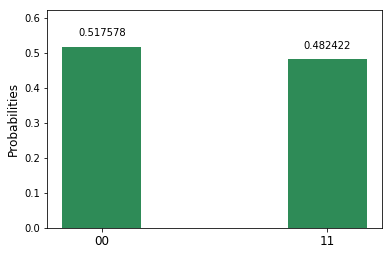

In [9]:
plot_histogram(data)

## Example 2

Now that you have run a single job, we'll show you how to run a batch of jobs.

In [10]:
make_ground = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
measure q[0] -> c[0];
"""
make_excited = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
x q[0];
measure q[0] -> c[0];
"""
make_superposition = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg c[1];
h q[0];
measure q[0] -> c[0];
"""

In [11]:
jobs = [{ 'qasm': make_ground},{ 'qasm': make_excited},{'qasm': make_superposition}]

print("submitting %d jobs ..." % len(jobs))
out = api.run_job(jobs, device = 'simulator',shots = 1024, max_credits=3)
print(out['status'])

submitting 3 jobs ...
RUNNING


In [12]:
jobids=out['id']
results = api.get_job(jobids)
print(results['status'])
while (results['status'] == 'RUNNING'):
    time.sleep(2)
    results = api.get_job(jobids)
    print(results['status'])

RUNNING
RUNNING
COMPLETED


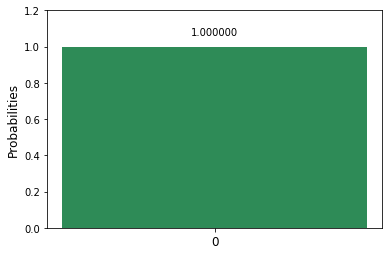

In [13]:
plot_histogram(get_data(results,0))

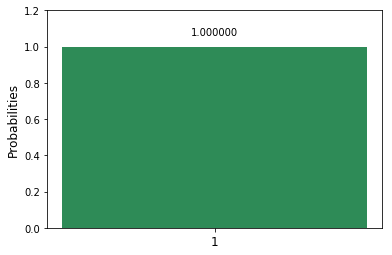

In [14]:
plot_histogram(get_data(results,1))

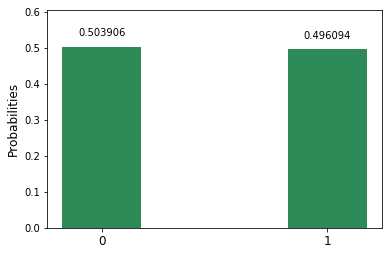

In [15]:
plot_histogram(get_data(results,2))